# Predikere sykehusopphold

#### Laster inn moduler 

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer, KNNImputer


#### Mer omfattende visning av datasett

In [248]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.expand_frame_repr", False)

#### Laster inn filer 

In [249]:
demographic_df = pd.read_csv("./raw_data/demographic.csv")
hospital_df = pd.read_csv("./raw_data/hospital.csv")
phychological_df = pd.read_csv("./raw_data/physiological.txt", sep="\t")
severity_df = pd.read_json("./raw_data/severity.json")

#### Analyserer demographic_df

In [250]:
print(f'Dimensjonen på demographic_df: {demographic_df.shape}')

# Sjekker om høyere antall rader skyldes duplikasjoner. 
duplicated_count = demographic_df.duplicated().sum()
print(f'Antall dupliserte pasienter: {duplicated_count}')

demographic_df.head()

Dimensjonen på demographic_df: (7742, 6)
Antall dupliserte pasienter: 2


,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet
0,2,60.33899,female,12.0,$11-$25k,white
1,3,52.74698,female,12.0,under $11k,white
2,4,42.38498,female,11.0,under $11k,white
3,5,79.88495,female,NaN,NaN,white
4,6,93.01599,male,14.0,NaN,white


In [251]:
demographic_df.describe(include="all")

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet
count,7742.000000,7742.000000,7742,6360.000000,5223,7705
unique,NaN,NaN,2,NaN,4,5
top,NaN,NaN,male,NaN,under $11k,white
freq,NaN,NaN,4370,NaN,2426,6120
mean,4539.500517,62.710904,NaN,11.752987,NaN,NaN
std,2637.118792,15.688113,NaN,3.458671,NaN,NaN
min,2.000000,-1.000000,NaN,0.000000,NaN,NaN
25%,2243.250000,52.915240,NaN,10.000000,NaN,NaN
50%,4538.500000,65.008000,NaN,12.000000,NaN,NaN
75%,6815.750000,74.131487,NaN,14.000000,NaN,NaN


#### Analyse av physiological_df

In [252]:
print(f'Dimensjonen på physiological_df: {phychological_df.shape}')
phychological_df.head()

Dimensjonen på physiological_df: (7740, 15)


,pasient_id,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,43.0,17.097656,112.0,34.0,34.59375,98.00000,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN
1,3,70.0,8.500000,88.0,28.0,37.39844,231.65625,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN
2,4,75.0,9.099609,88.0,32.0,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
3,5,59.0,13.500000,112.0,20.0,37.89844,173.31250,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN
4,6,110.0,10.398438,101.0,44.0,38.39844,266.62500,NaN,NaN,0.699951,140.0,7.659180,NaN,NaN,NaN


In [253]:
nan_values = phychological_df.isna().sum()
print(nan_values)

pasient_id                 0
blodtrykk                  0
hvite_blodlegemer        175
hjertefrekvens             0
respirasjonsfrekvens       0
kroppstemperatur           0
lungefunksjon           1944
serumalbumin            2849
bilirubin               2196
kreatinin                 57
natrium                    0
blod_ph                 1912
glukose                 3823
blodurea_nitrogen       3692
urinmengde              4113
dtype: int64


#### Substituerer NaN verdier i fysiologiske data med anbefalte eksempelverdier.

In [254]:
# Substituerer NaN verdier i phychological_df med eksempelverdier. 

phychological_df["serumalbumin"].fillna(3.5,inplace=True)
phychological_df["bilirubin"].fillna(1.01,inplace=True)
phychological_df["kreatinin"].fillna(1.01,inplace=True)
phychological_df["hvite_blodlegemer"].fillna(9,inplace=True) 
phychological_df["urinmengde"].fillna(2502,inplace=True)
phychological_df["blodurea_nitrogen"].fillna(6.5, inplace=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_31820\2189816738.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\andre\AppData\Local\Temp\ipykernel_31820\2189816738.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [255]:
phychological_df.describe(include="all")

,pasient_id,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
count,7740.000000,7740.000000,7740.000000,7740.000000,7740.000000,7740.000000,5796.000000,7740.000000,7740.000000,7740.000000,7740.000000,5828.000000,3917.000000,7740.00000,7740.000000
mean,4540.665375,84.412468,12.227368,97.283940,23.348450,37.116579,239.608379,3.154105,2.124243,1.784532,137.574160,7.415439,160.031146,20.14084,2353.639005
std,2636.463416,27.713746,9.017879,31.499505,9.549561,1.257278,109.942808,0.754716,4.555226,1.706914,6.029887,0.080844,87.828819,23.36813,1011.035013
min,2.000000,0.000000,0.000000,0.000000,0.000000,31.699220,12.000000,0.399963,0.099991,0.099991,110.000000,6.829102,0.000000,1.00000,0.000000
25%,2244.750000,63.000000,7.000000,72.000000,18.000000,36.195310,155.093750,2.699707,0.599976,0.899902,134.000000,7.379883,103.000000,6.50000,2050.000000
50%,4539.500000,77.000000,10.398438,100.000000,24.000000,36.695310,223.984375,3.500000,1.010000,1.199951,137.000000,7.419922,135.000000,6.50000,2502.000000
75%,6816.250000,107.000000,15.099609,120.000000,28.000000,38.195310,304.750000,3.500000,1.299805,1.899902,141.000000,7.469727,190.000000,25.00000,2502.000000
max,9105.000000,195.000000,128.781250,232.000000,90.000000,41.695310,869.375000,29.000000,63.000000,21.500000,181.000000,7.769531,1092.000000,192.00000,9000.000000


#### Analyserer hospital_df

In [256]:
print(f'Dimensjonen på hospital_df: {hospital_df.shape}')
hospital_df.head()

Dimensjonen på hospital_df: (7740, 3)


,pasient_id,sykehusdød,oppholdslengde
0,2,1,4
1,3,0,17
2,4,0,3
3,5,0,-99
4,6,1,4


In [257]:
hospital_df.describe(include="all")

,pasient_id,sykehusdød,oppholdslengde
count,7740.000000,7740.000000,7740.000000
mean,4540.665375,0.263178,17.728682
std,2636.463416,0.440387,21.995401
min,2.000000,0.000000,-99.000000
25%,2244.750000,0.000000,6.000000
50%,4539.500000,0.000000,11.000000
75%,6816.250000,1.000000,20.000000
max,9105.000000,1.000000,343.000000


#### Behandling og analyse av severity_df

In [258]:
severity_df.head()

,sykdomskategori_id,sykdomskategori,pasient_id,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
0,A1s,ARF/MOSF,"[5, 15, 18, 23, 28, 34, 39, 43, 46, 47, 48, 58...","[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, ...","[ARF/MOSF w/Sepsis, ARF/MOSF w/Sepsis, ARF/MOS...","[1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 3, 1, 3, ...","[26.0, 26.0, 26.0, 0.0, 26.0, 37.0, 0.0, 0.0, ...","[None, None, None, None, None, None, None, Non...","[2.0, None, 0.0, 5.0, 2.0, None, 0.0, None, No...","[23.5, 30.5, 40.296875, 31.6992188, 46.796875,...","[30.0, 39.0, 58.0, 42.0, 85.0, 49.0, 5.0, 76.0...","[0.6348876950000001, 0.590942383, 0.2129821780...","[0.5329589840000001, 0.481994629, 0.1169891360...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[no, no, no, no, yes, no, no, no, no, no, yes,...","[0.899999619, 0.899999619, 0.09999996400000001...","[0.9, 0.9, 0.001, 0.5, 0.000125, 0.60000000000...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
1,BrY,COPD/CHF/Cirrhosis,"[2, 3, 7, 8, 11, 13, 14, 19, 20, 30, 31, 32, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[Cirrhosis, Cirrhosis, CHF, CHF, CHF, Cirrhosi...","[2, 2, 1, 3, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, ...","[44.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[None, 1.0, 0.0, None, 2.0, 0.0, 0.0, 7.0, 3.0...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 7.0, None,...","[52.6953125, 20.5, 17.296875, 21.5976562, 14.5...","[74.0, 45.0, 46.0, 53.0, 14.0, 30.0, 34.0, 42....","[0.000999928, 0.790893555, 0.892944336, 0.6708...","[0.0, 0.6649169920000001, 0.820922852, 0.49896...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[no, no, no, no, no, no, no, no, no, no, no, n...","[0.0, 0.75, None, 0.799999714, 0.699999809, No...","[0.0, 0.5, 0.7000000000000001, 0.4, 0.5, None,...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
2,ChE,Cancer,"[4, 9, 10, 12, 16, 17, 21, 24, 27, 41, 42, 54,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[Lung Cancer, Lung Cancer, Colon Cancer, Lung ...","[2, 2, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 0, 1, ...","[0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0...","[0.0, None, 0.0, 1.0, 2.0, None, 0.0, None, No...","[0.0, 7.0, None, 1.0, 0.0, None, 0.0, None, No...","[20.0976562, 15.8984375, 2.2998047, 16.3984375...","[19.0, 17.0, 9.0, 17.0, 11.0, 4.0, 16.0, 11.0,...","[0.6989746090000001, 0.570922852, 0.9528808590...","[0.411987305, 0.24899292, 0.8879394530000001, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[metastatic, metastatic, metastatic, metastati...","[0.899999619, 0.049999982000000005, None, None...","[0.5, 0.000125, None, None, 0.7000000000000001...","[None, dnr ved innleggelse, None, None, None, ...","[None, 0.0, None, None, None, None, None, None..."
3,DWw,Coma,"[6, 162, 188, 250, 252, 262, 275, 309, 323, 35...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[Coma, Coma, Coma, Coma, Coma, Coma, Coma, Com...","[1, 0, 0, 2, 1, 2, 1, 0, 0, 1, 1, 0, 2, 2, 0, ...","[55.0, 61.0, 94.0, 55.0, 94.0, 100.0, 100.0, 5...","[None, None, None, None, None, None, None, Non...","[1.0, None, None, 1.0, None, None, None, None,...","[19.3984375, 30.3984375, 20.296875, 30.8984375...","[27.0, 36.0, 22.0, 53.0, 40.0, 25.0, 58.0, 16....","[0.28497314500000004, 0.438964844, 0.280944824...","[0.214996338, 0.365966797, 0.211975098, 0.2729...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[no, no, no, no, yes, no, no, no, no, no, no, ...","[0.0, None, None, None, None, 0.09999996400000...","[0.0, None, N

#### Bruker explode() på kolonner med lister for å utvide rader

In [259]:
columns_to_list = severity_df.columns.to_list()
valid_columns = columns_to_list[2:]
severity_df = severity_df.explode(valid_columns, ignore_index=True)

In [260]:
print(f'Dimensjonen på severity_df: {severity_df.shape}')
severity_df.head()

Dimensjonen på severity_df: (7740, 20)


,sykdomskategori_id,sykdomskategori,pasient_id,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
0,A1s,ARF/MOSF,5,0,ARF/MOSF w/Sepsis,1,26.0,None,2.0,23.5,30.0,0.634888,0.532959,0,0,no,0.9,0.9,None,None
1,A1s,ARF/MOSF,15,0,ARF/MOSF w/Sepsis,1,26.0,None,None,30.5,39.0,0.590942,0.481995,0,0,no,0.9,0.9,None,None
2,A1s,ARF/MOSF,18,1,ARF/MOSF w/Sepsis,0,26.0,None,0.0,40.296875,58.0,0.212982,0.116989,0,0,no,0.1,0.001,None,None
3,A1s,ARF/MOSF,23,0,ARF/MOSF w/Sepsis,1,0.0,None,5.0,31.699219,42.0,0.650879,0.55188,0,0,no,0.6,0.5,None,None
4,A1s,ARF/MOSF,28,1,MOSF w/Malig,1,26.0,None,2.0,46.796875,85.0,0.021,0.004999,0,0,yes,0.05,0.000125,None,None


In [261]:
severity_df.describe(include="all")

,sykdomskategori_id,sykdomskategori,pasient_id,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
count,7740,7740,7740,7740,7740,7740,7740.0,2942.0,5299.0,7740.000000,7740.0,7740.0,7740.0,7740,7740,7740,6319.0,6333.0,1070,1070.0
unique,4,4,7740,2,8,10,11.0,8.0,8.0,584.000000,124.0,939.0,935.0,2,2,3,48.0,80.0,2,18.0
top,A1s,ARF/MOSF,5,1,ARF/MOSF w/Sepsis,1,0.0,0.0,0.0,20.699219,32.0,0.0,0.0,0,0,no,0.5,0.5,dnr ved innleggelse,0.0
freq,3618,3618,1,5317,3002,2572,5419.0,1576.0,2633.0,52.000000,198.0,125.0,175.0,6222,7480,5086,892.0,947.0,858,896.0


#### Fjerner eventuelle duplikater, og sjekker dimensjoner

In [262]:
# Fjerner duplikater i demografisk data. Da har alle datasettene like mange rader, og kan sammenslås

demographic_df = demographic_df.drop_duplicates()

print('demographic_df: ', demographic_df.shape)
print('hospital_df: ', hospital_df.shape)
print('phychological_df: ', phychological_df.shape)
print('severity_df: ', severity_df.shape)

demographic_df:  (7740, 6)
hospital_df:  (7740, 3)
phychological_df:  (7740, 15)
severity_df:  (7740, 20)


#### Slår sammen alle datasettene

In [263]:
# Tilbakestiller indeksene.

demographic_df = demographic_df.reset_index(drop=True)
hospital_df = hospital_df.reset_index(drop=True).drop(columns=['pasient_id'])
phychological_df = phychological_df.reset_index(drop=True).drop(columns=['pasient_id'])
severity_df = severity_df.reset_index(drop=True).drop(columns=['pasient_id'])

# Slår så sammen datasettene til et stort datasett: df
df = pd.concat([demographic_df, hospital_df, phychological_df, severity_df], axis=1)

#### Databehandling


#### Analyserer sammenslått datasett

In [264]:
print(f'Dimensjon på DataFrame (df): {df.shape}')
df.head()

Dimensjon på DataFrame (df): (7740, 41)


,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
0,2,60.33899,female,12.0,$11-$25k,white,1,4,43.0,17.097656,112.0,34.0,34.59375,98.00000,3.5,1.010000,5.500000,132.0,7.250000,NaN,6.5,2502.0,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,1,26.0,None,2.0,23.5,30.0,0.634888,0.532959,0,0,no,0.9,0.9,None,None
1,3,52.74698,female,12.0,under $11k,white,0,17,70.0,8.500000,88.0,28.0,37.39844,231.65625,3.5,2.199707,2.000000,134.0,7.459961,NaN,6.5,2502.0,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,1,26.0,None,None,30.5,39.0,0.590942,0.481995,0,0,no,0.9,0.9,None,None
2,4,42.38498,female,11.0,under $11k,white,0,3,75.0,9.099609,88.0,32.0,35.00000,NaN,3.5,1.010000,0.799927,139.0,NaN,NaN,6.5,2502.0,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,0,26.0,None,0.0,40.296875,58.0,0.212982,0.116989,0,0,no,0.1,0.001,None,None
3,5,79.88495,female,NaN,NaN,white,0,-99,59.0,13.500000,112.0,20.0,37.89844,173.31250,3.5,1.010000,0.799927,143.0,7.509766,NaN,6.5,2502.0,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,1,0.0,None,5.0,31.699219,42.0,0.650879,0.55188,0,0,no,0.6,0.5,None,None
4,6,93.01599,male,14.0,NaN,white,1,4,110.0,10.398438,101.0,44.0,38.39844,266.62500,3.5,1.010000,0.699951,140.0,7.659180,NaN,6.5,2502.0,A1s,ARF/MOSF,1,MOSF w/Malig,1,26.0,None,2.0,46.796875,85.0,0.021,0.004999,0,0,yes,0.05,0.000125,None,None


In [265]:
df.describe(include="all")

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
count,7740.000000,7740.000000,7740,6359.000000,5222,7703,7740.000000,7740.000000,7740.000000,7740.000000,7740.000000,7740.000000,7740.000000,5796.000000,7740.000000,7740.000000,7740.000000,7740.000000,5828.000000,3917.000000,7740.00000,7740.000000,7740,7740,7740.0,7740,7740.0,7740.0,2942.0,5299.0,7740.000000,7740.0,7740.0,7740.0,7740.0,7740.0,7740,6319.0,6333.0,1070,1070.0
unique,NaN,NaN,2,NaN,4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,2.0,8,10.0,11.0,8.0,8.0,584.000000,124.0,939.0,935.0,2.0,2.0,3,48.0,80.0,2,18.0
top,NaN,NaN,male,NaN,under $11k,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1s,ARF/MOSF,1.0,ARF/MOSF w/Sepsis,1.0,0.0,0.0,0.0,20.699219,32.0,0.0,0.0,0.0,0.0,no,0.5,0.5,dnr ved innleggelse,0.0
freq,NaN,NaN,4370,NaN,2425,6118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3618,3618,5317.0,3002,2572.0,5419.0,1576.0,2633.0,52.000000,198.0,125.0,175.0,6222.0,7480.0,5086,892.0,947.0,858,896.0
mean,4540.665375,62.712258,NaN,11.753106,NaN,NaN,0.263178,17.728682,84.412468,12.227368,97.283940,23.348450,37.116579,239.608379,3.154105,2.124243,1.784532,137.574160,7.415439,160.031146,20.14084,2353.639005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2636.463416,15.688039,NaN,3.458930,NaN,NaN,0.440387,21.995401,27.713746,9.017879,31.499505,9.549561,1.257278,109.942808,0.754716,4.555226,1.706914,6.029887,0.080844,87.828819,23.36813,1011.035013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.000000,-1.000000,NaN,0.000000,NaN,NaN,0.000000,-99.000000,0.000000,0.000000,0.000000,0.000000,31.699220,12.000000,0.399963,0.099991,0.099991,110.000000,6.829102,0.000000,1.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2244.750000,52.921740,NaN,10.000000,NaN,NaN,0.000000,6.000000,63.000000,7.000000,72.000000,18.000000,36.195310,155.093750,2.699707,0.599976,0.899902,134.000000,7.379883,103.000000,6.50000,2050.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4539.500000,65.008000,NaN,12.000000,NaN,NaN,0.000000,11.000000,77.000000,10.398438,100.000000,24.000000,36.695310,223.984375,3.500000,1.010000,1.199951,137.000000,7.419922,135.000000,6.50000,2502.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,6816.250000,74.133747,NaN,14.000000,NaN,NaN,1.000000,20.000000,107.000000,15.099609,120.000000,28.000000,38.195310,304.750000,3.500000,1.299805,1.899902,141.000000,7.469727,190.000000,25.00000,2502.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Ser på verdier i datasettet (df) som ikke gir mening

In [266]:
# Merker fra df.describe() at det finnes pasienter med negativ oppholdslengde. Disse verdiene må behandles.

negativ_oppholdslengde = df[df["oppholdslengde"] < 0]
antall_negativ_oppholdslengde = len(negativ_oppholdslengde)

print(f'Det er {antall_negativ_oppholdslengde} pasienter med negativ oppholdslengde')

Det er 6 pasienter med negativ oppholdslengde


In [267]:
# Merker fra df.describe() at det finnes pasienter med negativ alder. Disse verdiene må behandles.

negativ_alder = df[df["alder"] < 0]
antall_negativ_alder = len(negativ_alder)

print(f'Det er {antall_negativ_alder} pasienter med negativ alder')


Det er 5 pasienter med negativ alder


#### Fjerner verdier og kolonner som ikke er relevante



In [268]:
# Filtrerer bort pasientene med negativ alder. 

df = df[df["alder"] >= 0]

# Disse kollonene kategoriserer jeg som irrelevante. Se rapport for begrunnelse.
irrelevant_columns = ["dødsfall", "pasient_id", "sykehusdød", "adl_pasient", "bilirubin", "sykdomskategori_id"]

df = df.drop(columns=irrelevant_columns, axis=1)

#### Deler inn i trenings-, validerings- og testdata

In [269]:
# Setter seed for random_state. Denne verdien er konsekvent gjennom hele prosjektet.
seed = 42

# Splitter data i trenings- og testsett. 
X = df.drop(columns=["oppholdslengde"])
y = df["oppholdslengde"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)

# Deler opp testsettet i validerings- og testsett.
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed, shuffle=True)

# Resetter indekser. Sikrer en konsistent struktur i dataene for videre behandling.
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True) 
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Feature engineering

In [270]:
#One hot encoder på kategorisk data.
cols_to_encode = ["kjønn", "inntekt", "etnisitet", "sykdomskategori", "sykdom_underkategori", "kreft", "dnr_status"]

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_transformed = one_hot_encoder.fit_transform(X_train[cols_to_encode])
X_train_encoded = pd.DataFrame(X_train_transformed, columns=one_hot_encoder.get_feature_names_out(cols_to_encode))
X_train_encoded = X_train_encoded.astype(int)

X_train = pd.concat([X_train.drop(columns=cols_to_encode).reset_index(drop=True), X_train_encoded], axis=1)

X_val_transformed = one_hot_encoder.transform(X_val[cols_to_encode])
X_val_encoded = pd.DataFrame(X_val_transformed, columns=one_hot_encoder.get_feature_names_out(cols_to_encode))
X_val_encoded = X_val_encoded.astype(int)

X_val = pd.concat([X_val.drop(columns=cols_to_encode).reset_index(drop=True), X_val_encoded], axis=1)

X_test_transformed = one_hot_encoder.transform(X_test[cols_to_encode])
X_test_encoded = pd.DataFrame(X_test_transformed, columns=one_hot_encoder.get_feature_names_out(cols_to_encode))
X_test_encoded = X_test_encoded.astype(int)

X_test = pd.concat([X_test.drop(columns=cols_to_encode).reset_index(drop=True), X_test_encoded], axis=1)

#### Analyserer treningsdataene

In [271]:
print(f'Dimensjonen på X_train: {X_train.shape}')
X_train.describe()

Dimensjonen på X_train: (5414, 58)


,alder,utdanning,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,kjønn_female,kjønn_male,inntekt_$11-$25k,inntekt_$25-$50k,inntekt_>$50k,inntekt_under $11k,inntekt_nan,etnisitet_asian,etnisitet_black,etnisitet_hispanic,etnisitet_other,etnisitet_white,etnisitet_nan,sykdomskategori_ARF/MOSF,sykdomskategori_COPD/CHF/Cirrhosis,sykdomskategori_Cancer,sykdomskategori_Coma,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,kreft_metastatic,kreft_no,kreft_yes,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,dnr_status_None
count,5414.000000,4438.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,4041.000000,5414.000000,5414.000000,5414.000000,4061.000000,2763.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000
mean,62.706516,11.779180,84.266069,12.377595,97.410473,23.456040,37.143871,238.610842,3.148956,1.759837,137.586812,7.415360,159.846544,20.133413,2351.722679,0.439970,0.560030,0.169560,0.113964,0.074252,0.314370,0.327854,0.008866,0.154414,0.032139,0.012006,0.787772,0.004802,0.462505,0.317510,0.155523,0.064463,0.381419,0.157370,0.107684,0.052457,0.056705,0.064463,0.098818,0.081086,0.200591,0.656631,0.142778,0.028629,0.111378,0.859993
std,15.555887,3.426343,27.913692,9.020940,31.642548,9.550289,1.267632,110.490405,0.783001,1.633534,6.119457,0.081014,88.405336,23.041631,1003.300054,0.496429,0.496429,0.375281,0.317797,0.262205,0.464307,0.469475,0.093749,0.361379,0.176385,0.108922,0.408923,0.069139,0.498638,0.465551,0.362436,0.245598,0.485780,0.364183,0.310009,0.222967,0.231299,0.245598,0.298445,0.272992,0.400480,0.474877,0.349879,0.166778,0.314629,0.347027
min,18.118990,0.000000,0.000000,0.000000,0.000000,0.000000,31.699220,32.000000,0.399963,0.099991,111.000000,6.829102,1.399902,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.870970,10.000000,63.000000,7.099609,72.000000,18.000000,36.195310,154.000000,2.599609,0.899902,134.000000,7.379883,103.000000,6.500000,2060.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,64.997955,12.000000,77.000000,10.500000,100.000000,24.000000,36.796880,223.781250,3.500000,1.199951,137.000000,7.419922,134.000000,7.000000,2502.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,74.045468,14.000000,107.000000,15.298828,120.000000,28.000000,38.195310,304.750000,3.500000,1.899902,141.000000,7.469727,189.000000,25.000000,2502.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000

## Visualisering av demografiske variabler

#### Aldersfordeling blant kjønnene i treningsdataene

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_gr

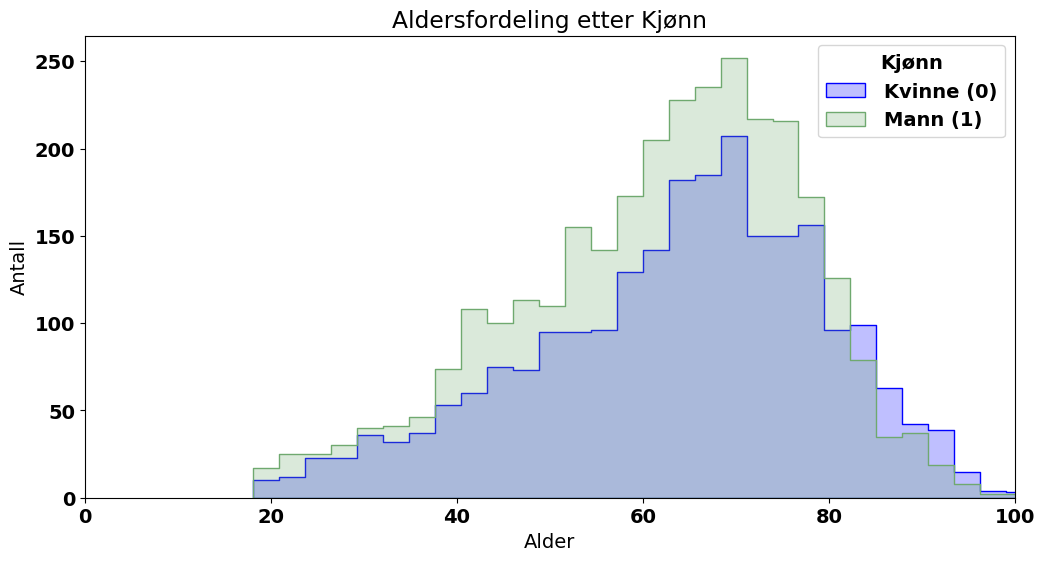

In [272]:
# Aldersfordeling blant kjønnene

plt.figure(figsize=(12, 6))

sns.histplot(data=X_train, 
             x='alder', 
             hue=X_train['kjønn_female'].map({1: 'Kvinne', 0: 'Mann'}), 
             bins=30, 
             element='step', 
             stat='count', 
             common_norm=False, 
             palette={'Mann': '#6FA96F', 'Kvinne': 'blue'},
             hue_order=['Mann', 'Kvinne'])

plt.xlim(0, 100)

plt.title('Aldersfordeling etter Kjønn')
plt.xlabel('Alder')
plt.ylabel('Antall')

plt.legend(title='Kjønn', loc='upper right', labels=['Kvinne (0)', 'Mann (1)'], handletextpad=1, frameon=True)

plt.show()

#### Oppholdslengde basert på alder

C:\Users\andre\AppData\Local\Temp\ipykernel_31820\3537645490.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\andre\AppData\Local\Temp\ipykernel_31820\3537645490.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the f

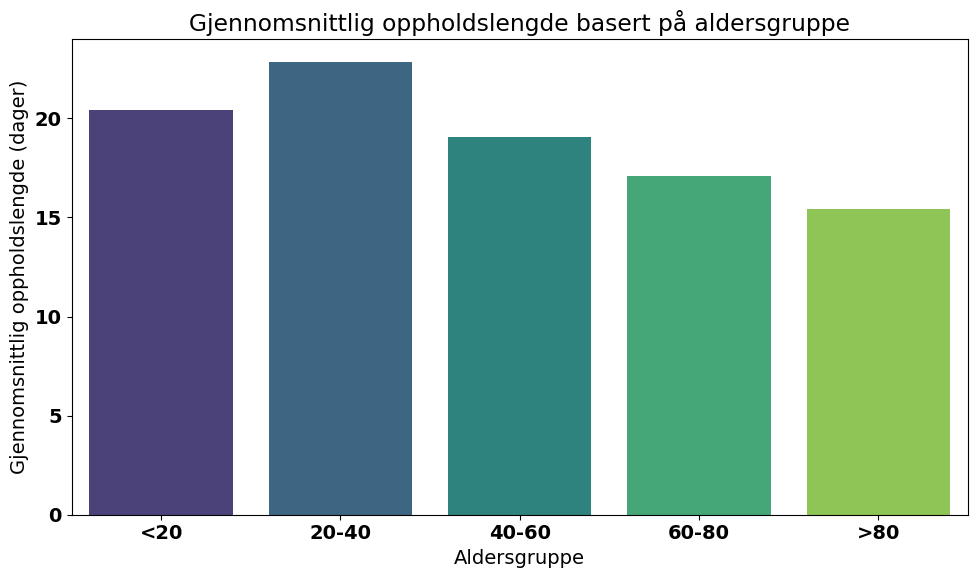

In [273]:
alders_grupper = [-1, 20, 40, 60, 80, 100] 
navn_aldersgrupper = ['<20', '20-40', '40-60', '60-80', '>80']

X_train['alder_gruppe'] = pd.cut(X_train['alder'], bins=alders_grupper, labels=navn_aldersgrupper)

gjennomsnitt_oppholdslengde_per_aldergruppe = X_train.groupby('alder_gruppe').apply(
    lambda x: y_train[x.index].mean()
).reset_index(name='Gjennomsnittlig oppholdslengde')

plt.figure(figsize=(10, 6))
sns.barplot(data=gjennomsnitt_oppholdslengde_per_aldergruppe, x='alder_gruppe', y='Gjennomsnittlig oppholdslengde', palette='viridis')
plt.title('Gjennomsnittlig oppholdslengde basert på aldersgruppe')
plt.xlabel('Aldersgruppe')
plt.ylabel('Gjennomsnittlig oppholdslengde (dager)')
plt.tight_layout()
plt.show()

X_train.drop(columns=['alder_gruppe'], inplace=True)

#### Gjennomsnittlig oppholdslengde etter kjønn i treningsdataene

In [274]:
combined_df = X_train.copy()
combined_df['oppholdslengde'] = y_train

opphold_by_gender = combined_df.groupby(['kjønn_female']).agg({'oppholdslengde': 'mean'}).reset_index()
opphold_by_gender['Kjønn'] = opphold_by_gender['kjønn_female'].map({1: 'Kvinne', 0: 'Mann'})
opphold_by_gender['Gjennomsnittlig Oppholdslengde (dager)'] = round(opphold_by_gender['oppholdslengde'], 1)

fig1 = px.bar(opphold_by_gender, 
              x='Kjønn', 
              y='Gjennomsnittlig Oppholdslengde (dager)',
              title='Gjennomsnittlig Oppholdslengde etter Kjønn',
              labels={'Gjennomsnittlig Oppholdslengde (dager)': 'Oppholdslengde (dager)', 'Kjønn': 'Kjønn'},
              color='Kjønn',
              color_discrete_map={"Kvinne": "#A3C1DA", "Mann": "#B2D8B2"},
              text='Gjennomsnittlig Oppholdslengde (dager)', 
              width=1000, height = 400)


fig1.update_traces(texttemplate='%{text:.2f}', textposition='inside')

fig1.update_layout(bargap=0.1)
fig1.show()

#### Påvirker inntekt oppholdslengde?

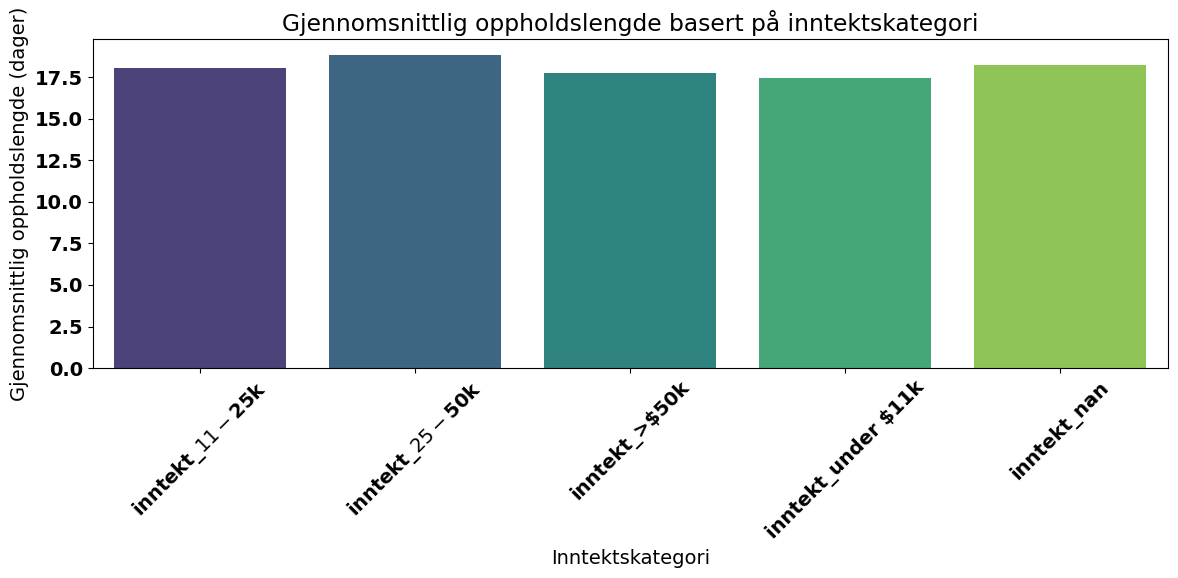

In [275]:
inntektskategorier = [col for col in X_train.columns if 'inntekt' in col]

resultater = []

for inntekt in inntektskategorier:
    
    total = X_train[X_train[inntekt] == 1].shape[0]
    
    if total > 0:
        gjennomsnitt_oppholdslengde = y_train[X_train[inntekt] == 1].mean()
        resultater.append({'Inntektskategori': inntekt, 'Gjennomsnittlig oppholdslengde': gjennomsnitt_oppholdslengde})

resultater_df = pd.DataFrame(resultater)

plt.figure(figsize=(12, 6))
sns.barplot(data=resultater_df, x='Inntektskategori', y='Gjennomsnittlig oppholdslengde', palette='viridis')
plt.title('Gjennomsnittlig oppholdslengde basert på inntektskategori')
plt.xlabel('Inntektskategori')
plt.ylabel('Gjennomsnittlig oppholdslengde (dager)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualisering av sykdomsrelaterte variabler

#### Oversikt over oppholdslengde blant alle pasientene i treningsdataene

Gjennomsnittlig oppholdslengde i treningsdata: 17.995012929442186 dager
Korteste oppholdslengde på sykehuset: -99 dager


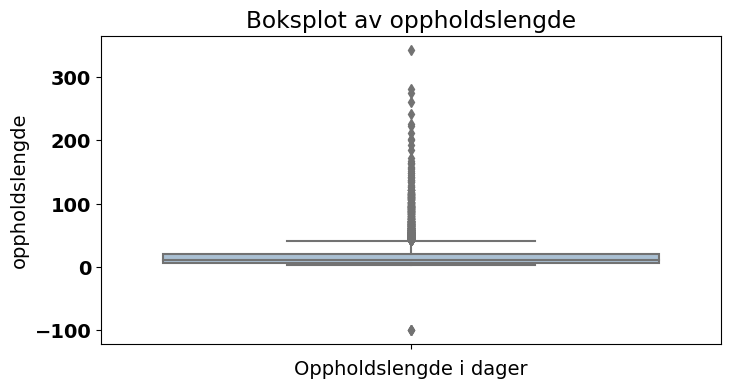

In [276]:
print(f'Gjennomsnittlig oppholdslengde i treningsdata: {y_train.mean()} dager')
print(f'Korteste oppholdslengde på sykehuset: {min(y_train)} dager')

plt.figure(figsize=(8, 4))
sns.boxplot(y=y_train, color='#A3C1DA')

plt.title('Boksplot av oppholdslengde')
plt.xlabel('Oppholdslengde i dager')
plt.show()

In [277]:
# Ser i boksplottet at det finnes pasient(er) med negativ oppholdslengde. Bytter ut negativ oppholdslengde med median oppholdslengde.

median_oppholdslenge = y_train.median()
y_train = y_train.where(y_train >= 0, median_oppholdslenge)
y_val = y_val.where(y_val >= 0, median_oppholdslenge)
y_test = y_test.where(y_test >= 0, median_oppholdslenge)

#### Forekomst av sykdomskategorier blant etnisiteter i treningsdataene

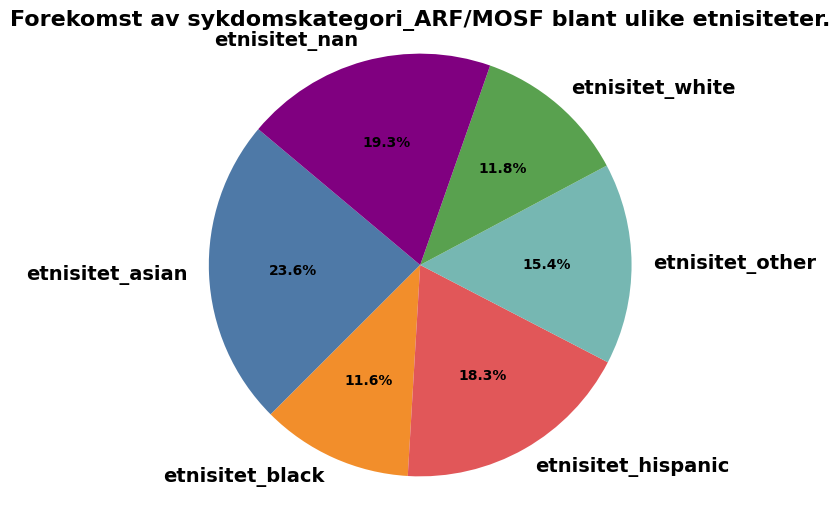

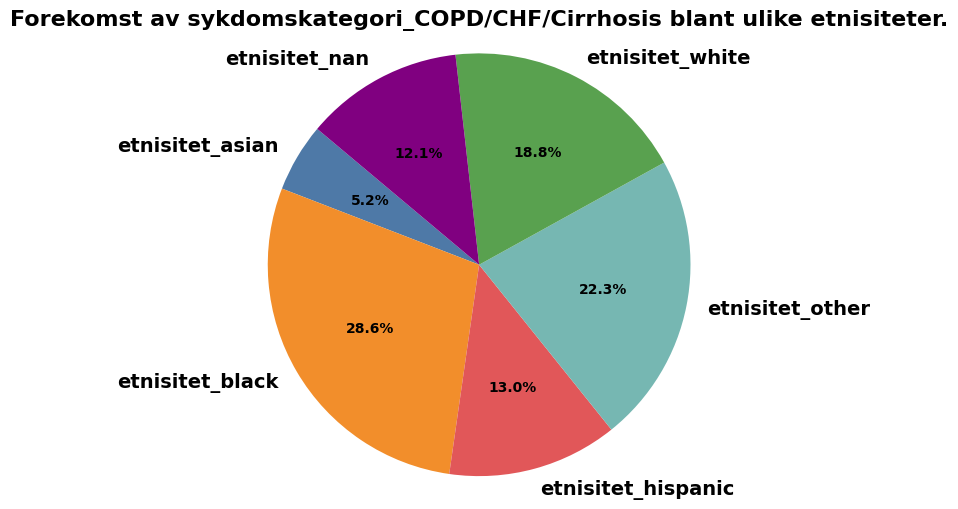

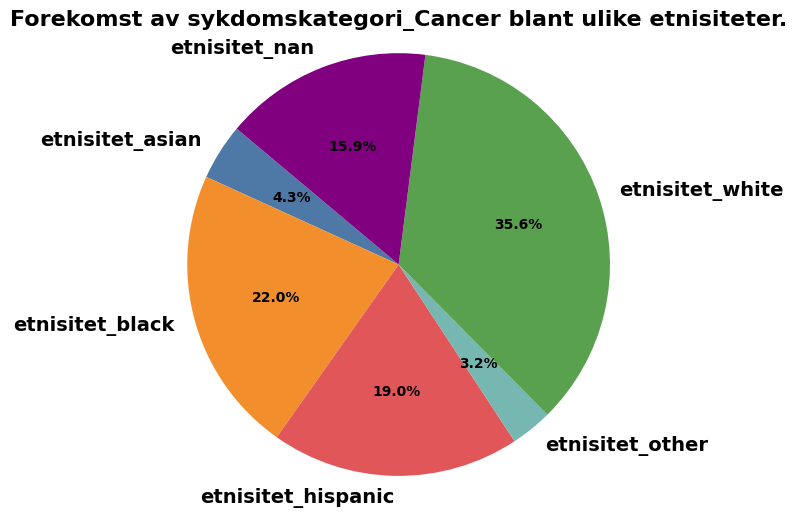

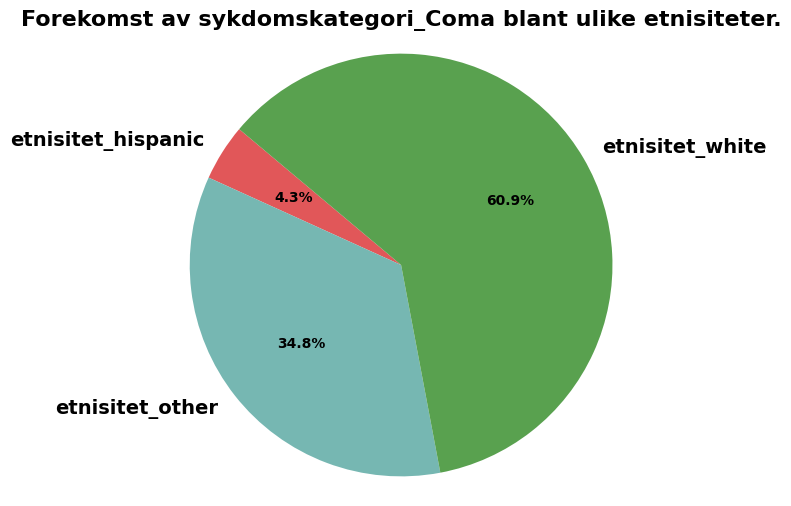

In [278]:
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', "purple"]

ethnicities = ['etnisitet_asian', 'etnisitet_black', 'etnisitet_hispanic', 'etnisitet_other', 'etnisitet_white', "etnisitet_nan"]

disease_categories = ['sykdomskategori_ARF/MOSF', 
                     'sykdomskategori_COPD/CHF/Cirrhosis', 
                     'sykdomskategori_Cancer', 
                     'sykdomskategori_Coma']

total_ethnicity_counts = X_train[ethnicities].sum()

plt.rcParams.update({'font.size': 14, 'font.weight': 'bold'}) 

for disease in disease_categories:
    disease_data = X_train[X_train[disease] == 1][ethnicities].sum()

    percentage_data = (disease_data / total_ethnicity_counts) * 100
    
    # Sjekker om noen etnisiteter har en andel på 0%
    percentage_data = percentage_data[percentage_data > 0]
    
    if not percentage_data.empty:
        plt.figure(figsize=(6, 6))

        selected_colors = [colors[ethnicities.index(ethnicity)] for ethnicity in percentage_data.index]
        
        wedges, texts, autotexts = plt.pie(percentage_data, labels=percentage_data.index, 
                                           autopct='%1.1f%%', startangle=140, 
                                           colors=selected_colors, 
                                           textprops={'fontsize': 10})
        
        plt.title(f'Forekomst av {disease} blant ulike etnisiteter.', fontsize=16, fontweight='bold')
        
        plt.axis('equal') 
        
        for text in texts:
            text.set_fontsize(14)
            text.set_fontweight('bold')
        
        plt.show()

#### Korrelasjonsmatrise for fysiologiske variabler i treningsdataene


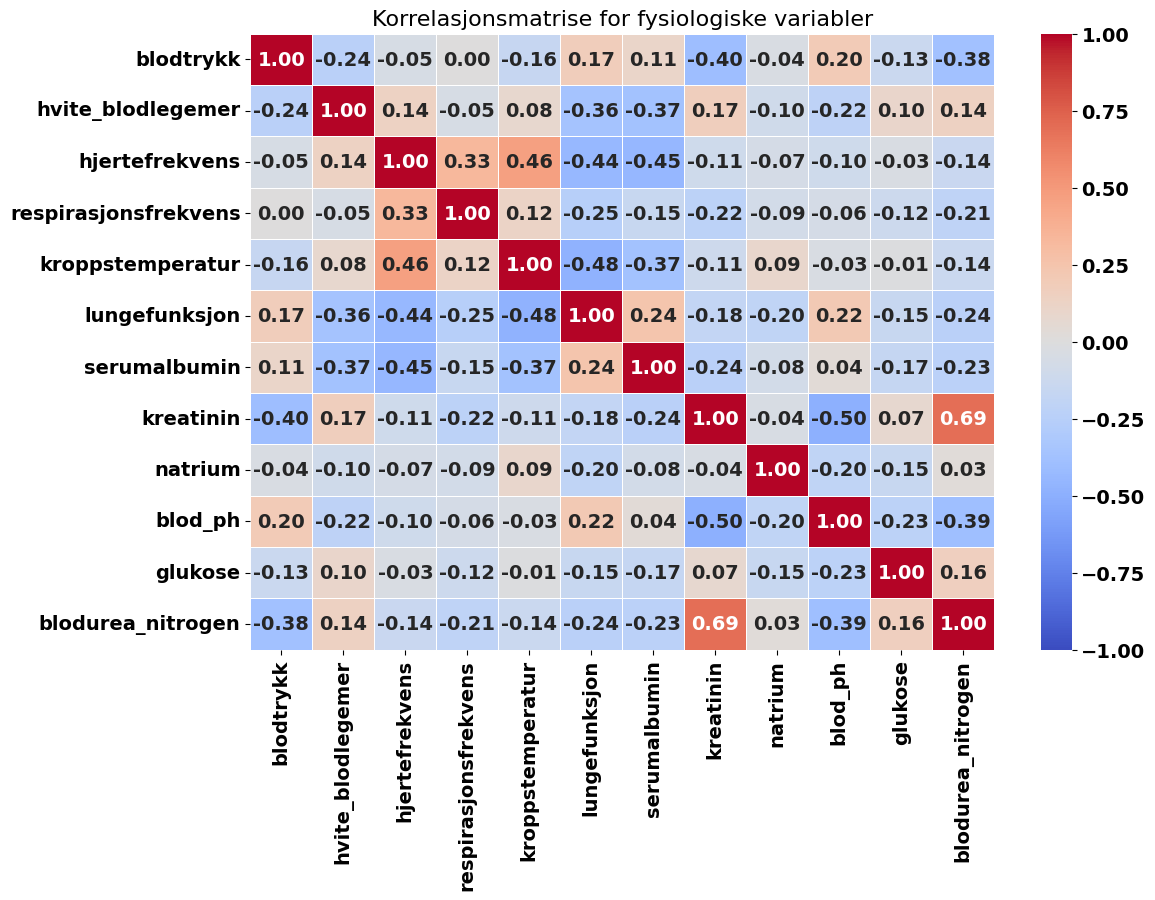

In [279]:
# Korrelasjonsmatrise for fysiologiske variabler

phychological_columns =  [
    'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens', 
    'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon', 
    'serumalbumin', 'kreatinin', 'natrium', 
    'blod_ph', 'glukose', 'blodurea_nitrogen'
]

# Korrelasjonsmatrise over kun fysiologiske variabler i treningssettet
korrelasjons_matrise = X_train[phychological_columns].corr()
korrelasjons_matrise = korrelasjons_matrise.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(korrelasjons_matrise, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Korrelasjonsmatrise for fysiologiske variabler', fontsize=16)
plt.show()

#### Korrelasjonsmatrise for sykdomsalvorlighetsvariabler i treningsdataene

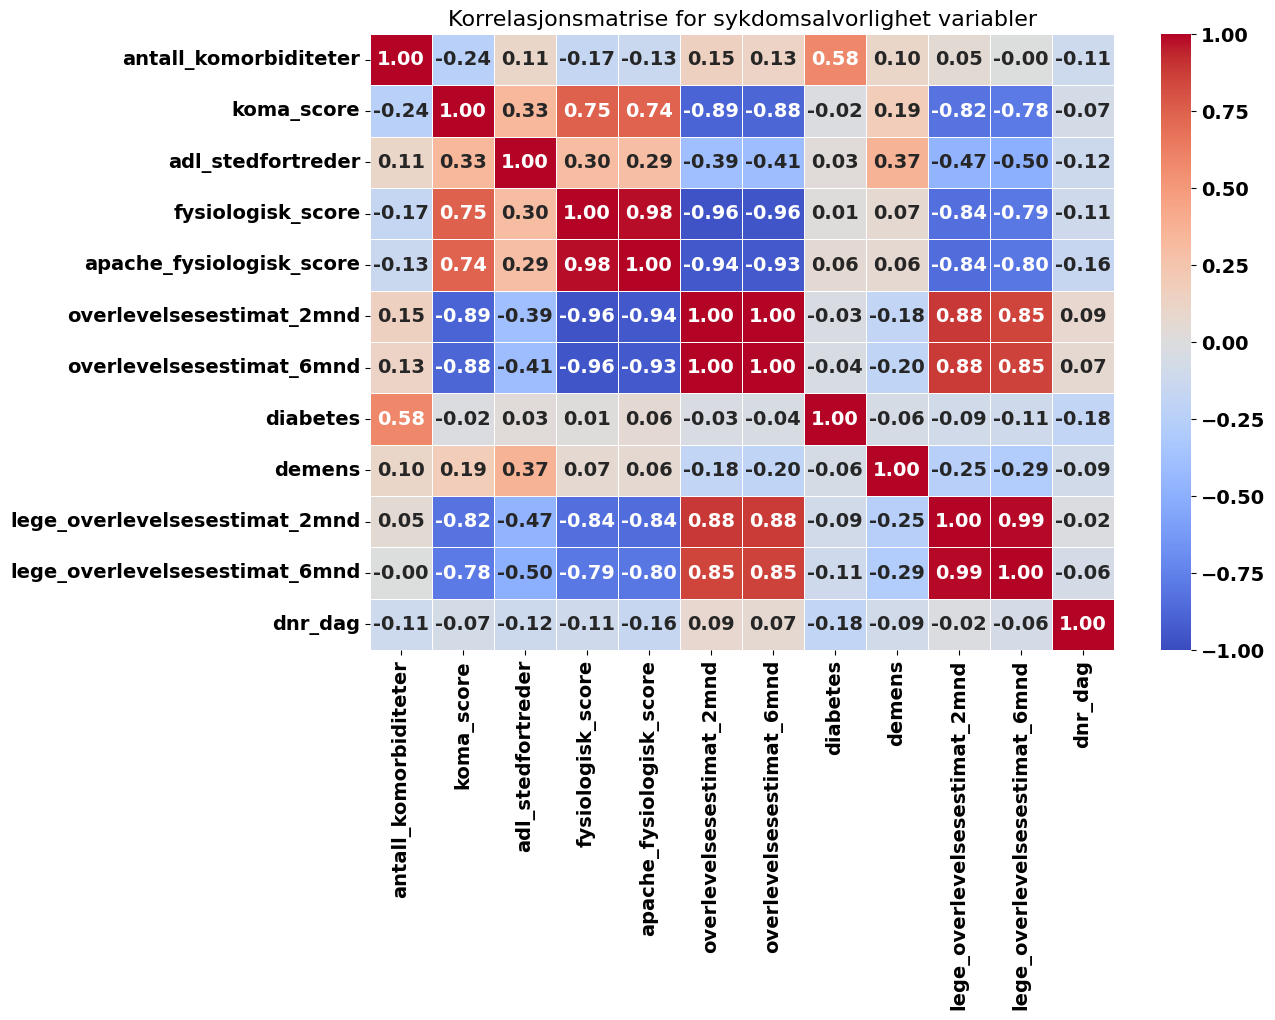

In [280]:
# Korrelasjonsmatrise for variabler i sykdomsalvorlighetsdata.

severity_columns = ['antall_komorbiditeter', 'koma_score',
       'adl_stedfortreder', 'fysiologisk_score', 'apache_fysiologisk_score',
       'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes',
       'demens','lege_overlevelsesestimat_2mnd',
       'lege_overlevelsesestimat_6mnd', 'dnr_dag']


#Korrelasjonsmatrise over sykdomsalvorlighetsdata i treningssettet
korrelasjons_matrise = X_train[severity_columns].corr()
korrelasjons_matrise = korrelasjons_matrise.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(korrelasjons_matrise, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Korrelasjonsmatrise for sykdomsalvorlighet variabler', fontsize=16)
plt.show()

#### Fjerner variabler som korrelerer mer enn +-0.95

In [281]:
# Fra korrelasjonsmatrisen over merker vi oss variablene som korrelerer mer enn +-0.95.

høyt_korrelerende_variabler = ["lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd", "apache_fysiologisk_score"]

X_train = X_train.drop(columns=høyt_korrelerende_variabler)
X_val = X_val.drop(columns=høyt_korrelerende_variabler)
X_test = X_test.drop(columns=høyt_korrelerende_variabler) # fjerner fra testdata for å være konsistent.

#### Undersøker fysiologiske uteliggere i treningsdataene

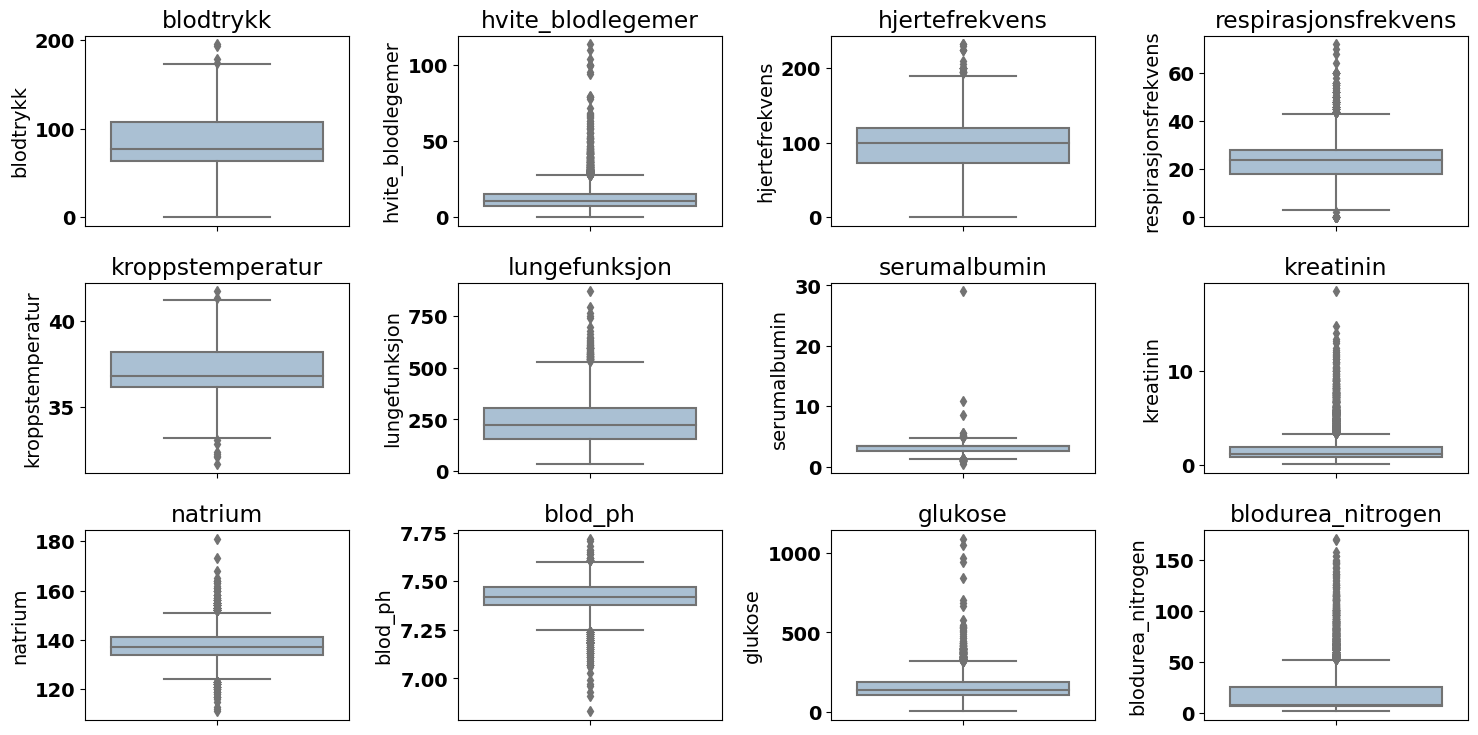

In [282]:
# Alle fysiologiske variablene i treningssettet.
phychological_columns =  [
    'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens', 
    'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon', 
    'serumalbumin', 'kreatinin', 'natrium', 
    'blod_ph', 'glukose', 'blodurea_nitrogen'
]

plt.figure(figsize=(15, 10))
for i, column in enumerate(phychological_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=X_train, y=column, color="#A3C1DA")
    plt.title(column)
plt.tight_layout()
plt.show()

#### Oversikt over overlevelsesestimat blant pasientene (2 mnd og 6 mnd) i treningsdataene.

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



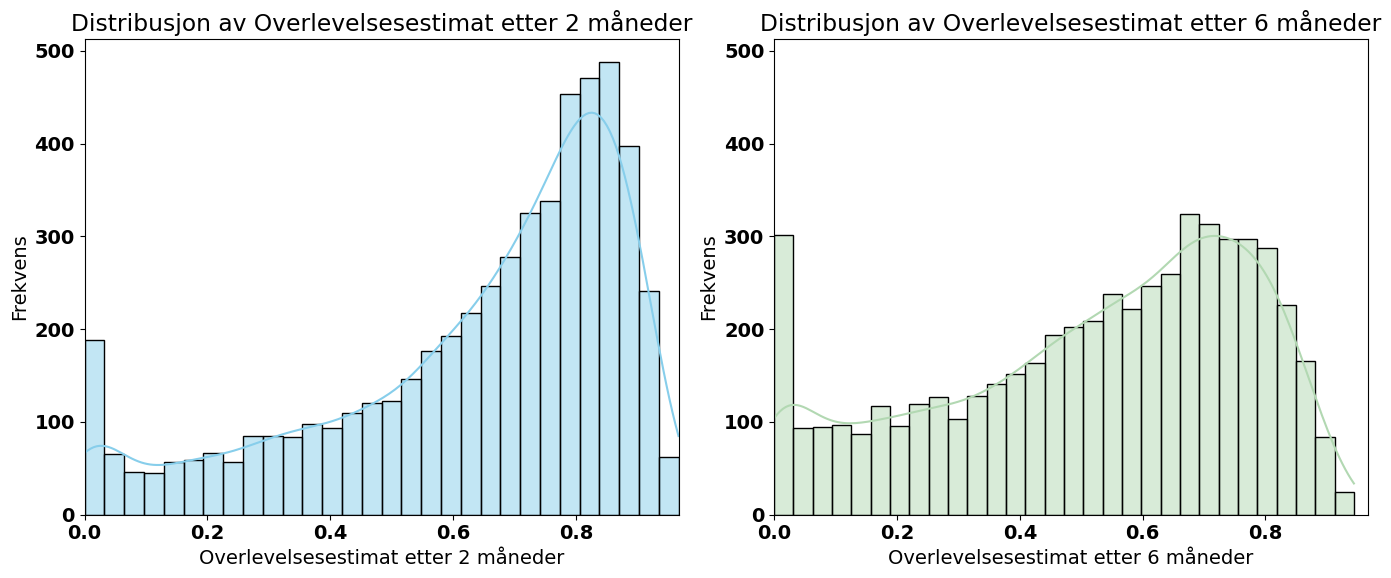

In [283]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram overlevelsesestimat (2 måneder).
sns.histplot(X_train['overlevelsesestimat_2mnd'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribusjon av Overlevelsesestimat etter 2 måneder')
axes[0].set_xlabel('Overlevelsesestimat etter 2 måneder')
axes[0].set_ylabel('Frekvens')

# Histogram overlevelsesestimat (6 måneder).
sns.histplot(X_train['overlevelsesestimat_6mnd'], bins=30, kde=True, ax=axes[1], color='#B2D8B2')
axes[1].set_title('Distribusjon av Overlevelsesestimat etter 6 måneder')
axes[1].set_xlabel('Overlevelsesestimat etter 6 måneder')
axes[1].set_ylabel('Frekvens')

x_limits = (min(X_train['overlevelsesestimat_2mnd'].min(), X_train['overlevelsesestimat_6mnd'].min()), 
            max(X_train['overlevelsesestimat_2mnd'].max(), X_train['overlevelsesestimat_6mnd'].max()))
y_limits = (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])) 

axes[0].set_xlim(x_limits)
axes[1].set_xlim(x_limits)
axes[0].set_ylim(y_limits)
axes[1].set_ylim(y_limits)

plt.tight_layout()
plt.show()

## Modellering

#### Sjekker dimensjonene i trenings- og valideringsdataene for modellering

In [284]:
# Dimensjonene må matche for å kunne modellere

print(f'Størrelse på X_train: {X_train.shape[0]}')
print(f'Størrelse på y_train: {y_train.shape[0]}')
print(f'Størrelse på X_val: {X_val.shape[0]}')
print(f'Størrelse på y_val: {y_val.shape[0]}')

Størrelse på X_train: 5414
Størrelse på y_train: 5414
Størrelse på X_val: 1160
Størrelse på y_val: 1160


#### Undersøker hvilke kolonner det fremdeles finnes NaN verdier i. Disse behandles av imputeringsmetodene i modellene

In [285]:
# Undersøker hvilke kolonner det finnes NaN verdier i. 

nan_counts = X_train.isna().sum()

nan_counts = nan_counts[nan_counts > 0]

if not nan_counts.empty:
    print("NaN verdier funnet i følgende kolonner:")
    print(nan_counts)
else:
    print("Ingen NaN verdier funnet i spesifiserte kolonner.")

NaN verdier funnet i følgende kolonner:
utdanning             976
lungefunksjon        1373
blod_ph              1353
glukose              2651
adl_stedfortreder    1699
dnr_dag              4656
dtype: int64


#### Modell 1: Grunnlinjemodell

In [286]:
# Modell 1: Grunnlinjemodell

median_oppholdslenge = y_train.median()
print(f'Median oppholdslengde: {median_oppholdslenge}\n')


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

baseline = DummyRegressor(strategy="median")  # Modellen predikerer alltid medianverdien av den avhengige variabelen, og håndterer NaN-verdier ved å ignorere dem under beregningen av medianen.

baseline.fit(X_train, y_train)
prediction = baseline.predict(X_val) 
rmse_baseline = root_mean_squared_error(y_val, prediction) 
print(f'RMSE for grunnlinjemodell: {rmse_baseline}')

Median oppholdslengde: 11.0

RMSE for grunnlinjemodell: 21.24118478415182


#### Oppretter Pipeline

In [287]:
# Oppretter en Pipeline. Denne brukes i RandomizedSearchCV. 

pipeline = Pipeline([ # Pipelinen prosesserer dataene og håndterer NaN-verdier ved hjelp av imputeringsmetoder og dataskalering.
    ('strat', 'passthrough'), 
    ('scaler', 'passthrough'), 
    ('model', 'passthrough')   
])

#### Modell 2: Gradient Boosting Regressor

In [288]:
# Modell 2: Gradient Boosting Regressor.  

# Hyperparametre for Gradient Boosting Regressor. 
gradient_boosting_parametre = [
    {
        'strat': [SimpleImputer()],
        'strat__strategy': ['mean', 'median'],
        'scaler': [StandardScaler()],
        'model': [GradientBoostingRegressor(random_state=42)],
        'model__n_estimators': [100, 200, 500],
        'model__learning_rate': [0.01, 0.1, 0.05],
        'model__max_depth': [3, 5, 7]
    },
    {
        'strat': [KNNImputer()],
        'strat__n_neighbors': [3, 5],
        'scaler': [StandardScaler()],
        'model': [GradientBoostingRegressor(random_state=42)],
        'model__n_estimators': [100, 200, 500],
        'model__learning_rate': [0.01, 0.1, 0.05],
        'model__max_depth': [3, 5, 7]
    }
]

# RandomizedSearchCV for Ranodm Forest Regressor.
gb_search = RandomizedSearchCV(pipeline, gradient_boosting_parametre, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, random_state=42)
gb_search.fit(X_train, y_train)

# Få beste modell og hyperparametere. 
best_gb = gb_search.best_estimator_
print(f"Beste hyperparametere for GradientBoosting: {gb_search.best_params_}")
gb_rmse = root_mean_squared_error(y_val, best_gb.predict(X_val))
print(f"Beste RMSE for GradientBoosting: {gb_rmse}")

Beste hyperparametere for GradientBoosting: {'strat__strategy': 'mean', 'strat': SimpleImputer(), 'scaler': StandardScaler(), 'model__n_estimators': 500, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model': GradientBoostingRegressor(random_state=42)}
Beste RMSE for GradientBoosting: 20.034828660401274


#### Modell 3: Random Forest Regressor

In [289]:
# Modell 3: Random Forest Regressor. 

# Hyperparametere for Random Forest Regressor.
random_forest_parametre = [
    {
        'strat': [SimpleImputer()],
        'strat__strategy': ['mean', 'median'],
        'scaler': [StandardScaler()],
        'model': [RandomForestRegressor(random_state=42)],
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [5, 10, 15],
        'model__min_samples_split': [2, 5, 10]
    },
    {
        'strat': [KNNImputer()],
        'strat__n_neighbors': [3, 5],
        'scaler': [StandardScaler()],
        'model': [RandomForestRegressor(random_state=42)],
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [5, 10, 15],
        'model__min_samples_split': [2, 5, 10]
    }
]

# RandomizedSearchCV for Ranodm Forest Regressor.
rf_search = RandomizedSearchCV(pipeline, random_forest_parametre, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)


# Få beste modell og hyperparametere. 
best_rf = rf_search.best_estimator_
print(f"Beste hyperparametere for RandomForest: {rf_search.best_params_}")
rf_rmse = root_mean_squared_error(y_val, best_rf.predict(X_val))
print(f"Beste RMSE for RandomForest: {rf_rmse}")


Beste hyperparametere for RandomForest: {'strat__strategy': 'mean', 'strat': SimpleImputer(), 'scaler': StandardScaler(), 'model__n_estimators': 500, 'model__min_samples_split': 2, 'model__max_depth': 5, 'model': RandomForestRegressor(random_state=42)}
Beste RMSE for RandomForest: 19.98220535673033


#### Modell 4: Elastic Net

In [290]:
# Modell 4: Elastic Net.

# Hyperparametere for Elastic Net
elastic_net_parametere = [
    {
        'strat': [SimpleImputer()],
        'strat__strategy': ['mean', 'median'],
        'scaler': [StandardScaler()],
        'model': [ElasticNet(random_state=42)],
        'model__alpha': [0.1, 0.5, 1.0],
        'model__l1_ratio': [0.1, 0.5, 0.9]
    },
    {
        'strat': [KNNImputer()],
        'strat__n_neighbors': [3, 5],
        'scaler': [StandardScaler()],
        'model': [ElasticNet(random_state=42)],
        'model__alpha': [0.1, 0.5, 1.0],
        'model__l1_ratio': [0.1, 0.5, 0.9]
    }
]

# Randomized Search for Elastic Net
en_search = RandomizedSearchCV(pipeline, elastic_net_parametere, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, random_state=42)

en_search.fit(X_train, y_train)


# Få beste modell og hyperparametere
best_en = en_search.best_estimator_
print(f"Beste hyperparametere for ElasticNet: {en_search.best_params_}")
en_rmse = root_mean_squared_error(y_val, best_en.predict(X_val))
print(f"Beste RMSE for ElasticNet: {en_rmse}")


Beste hyperparametere for ElasticNet: {'strat__n_neighbors': 3, 'strat': KNNImputer(), 'scaler': StandardScaler(), 'model__l1_ratio': 0.5, 'model__alpha': 0.5, 'model': ElasticNet(random_state=42)}
Beste RMSE for ElasticNet: 20.084847773239574


#### Utforsker viktigheten av variablene på beste modellens ytelse

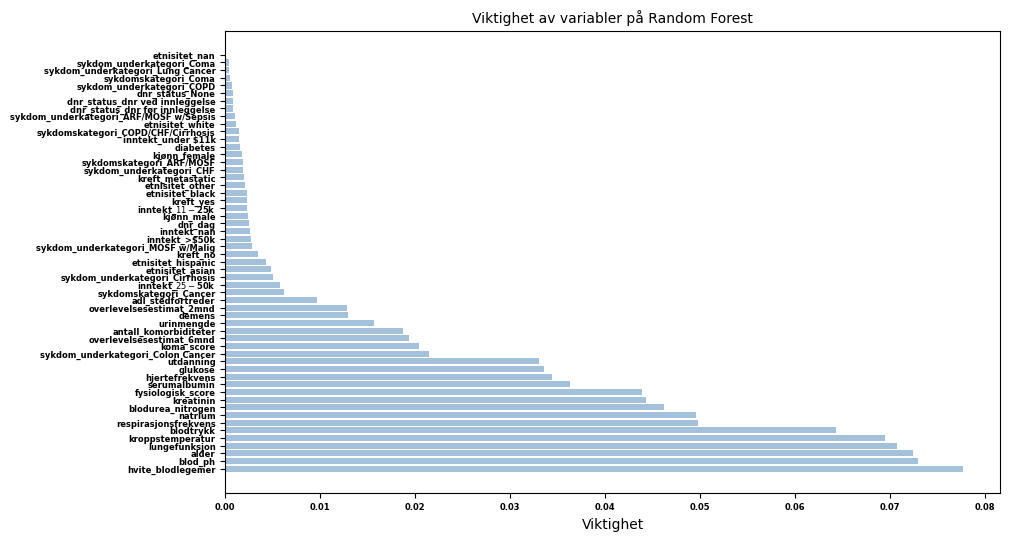

In [291]:
rf_model = best_rf.named_steps['model']

feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#A3C1DA')
plt.xlabel('Viktighet', fontsize=10)
plt.title('Viktighet av variabler på Random Forest', fontsize=10)
plt.xticks(fontsize=6) 
plt.yticks(fontsize=6)
plt.show()

#### Sjekker for beste modell

In [292]:
# Modellresultater
model_results = [
    {'Model': 'Grunnlinjemodell', 'RMSE': rmse_baseline},
    {'Model': 'ElasticNet', 'RMSE': en_rmse},
    {'Model': 'RandomForest', 'RMSE': rf_rmse},
    {'Model': 'GradientBoosting', 'RMSE': gb_rmse}
]

# Opprett DataFrame og sorter etter RMSE
rmse_df = pd.DataFrame(model_results)
rmse_df = rmse_df.sort_values(by='RMSE').reset_index(drop=True)

# Finn den optimale modellen
optimal_model = rmse_df.iloc[0]

# Skriv ut tabellen med RMSE
display(rmse_df)

# Skriv ut den optimale modellen og RMSE
print("Beste modell:", optimal_model['Model'], "med RMSE:", optimal_model['RMSE'])


,Model,RMSE
0,RandomForest,19.982205
1,GradientBoosting,20.034829
2,ElasticNet,20.084848
3,Grunnlinjemodell,21.241185


Beste modell: RandomForest med RMSE: 19.98220535673033


#### Generaliseringesevne

In [293]:
# Modellene som trenes.
models = {
    'elastic_net': best_en,
    'gradient_boosting': best_gb,
    'random_forest': best_rf,
    'baseline': baseline
}

# RMSE for modellene.
RMSE_models = {
    'elastic_net': en_rmse,
    'gradient_boosting': gb_rmse,
    'random_forest': rf_rmse,
    'baseline': rmse_baseline
}

optimal_model_name, optimal_rmse = min(RMSE_models.items(), key=lambda x: x[1])
optimal_model = models[optimal_model_name]

y_test_predikert = optimal_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_test_predikert)

print(f"Test RMSE for beste modell ({optimal_model_name}): {test_rmse}")

Test RMSE for beste modell (random_forest): 19.130643601108797


#### Visualisering av modellenes ytelse og generaliseringsevne

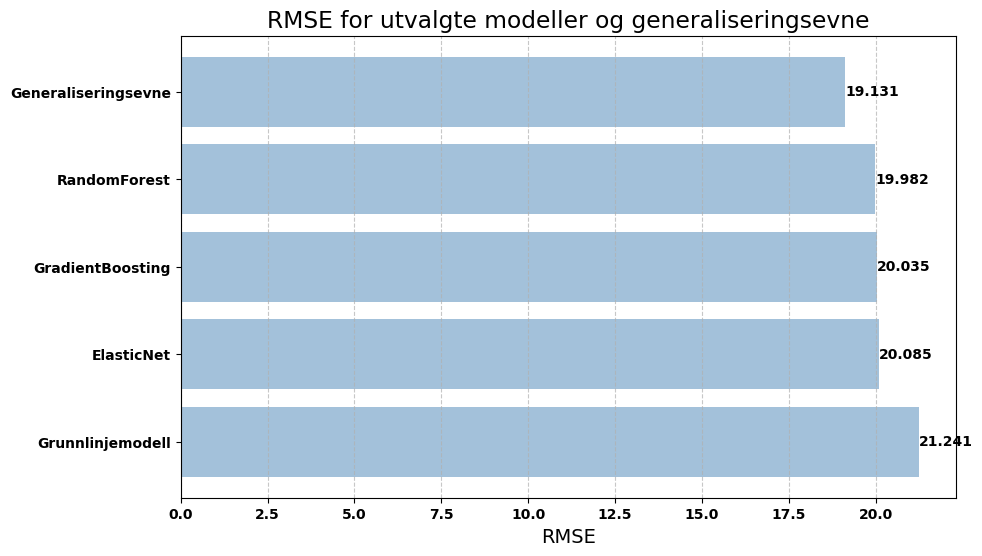

In [294]:
# Inkludere alle resultatene i alle_modeller.

alle_modeller = [
    {'Model': 'Grunnlinjemodell', 'RMSE': rmse_baseline},
    {'Model': 'ElasticNet', 'RMSE': en_rmse},
    {'Model': 'RandomForest', 'RMSE': rf_rmse},
    {'Model': 'GradientBoosting', 'RMSE': gb_rmse},
    {"Model": "Generaliseringsevne", "RMSE": test_rmse}
]

rmse_df = pd.DataFrame(alle_modeller)
rmse_df = rmse_df.sort_values(by='RMSE').reset_index(drop=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(rmse_df['Model'], rmse_df['RMSE'], color='#A3C1DA')
plt.xlabel('RMSE')
plt.title('RMSE for utvalgte modeller og generaliseringsevne')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()

# Legger til RMSE resultat på barene.
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.3f}', 
             va='center', ha='left', fontsize=10)

plt.show()

#### Predikerte sammenliknet med faktiske oppholdslengder

Lengste predikerte oppholdslengde: 43.28
Korteste predikerte oppholdslengde: 12.89
Median faktisk oppholdslengde: 11.0
Median predikert oppholdslengde: 17.55


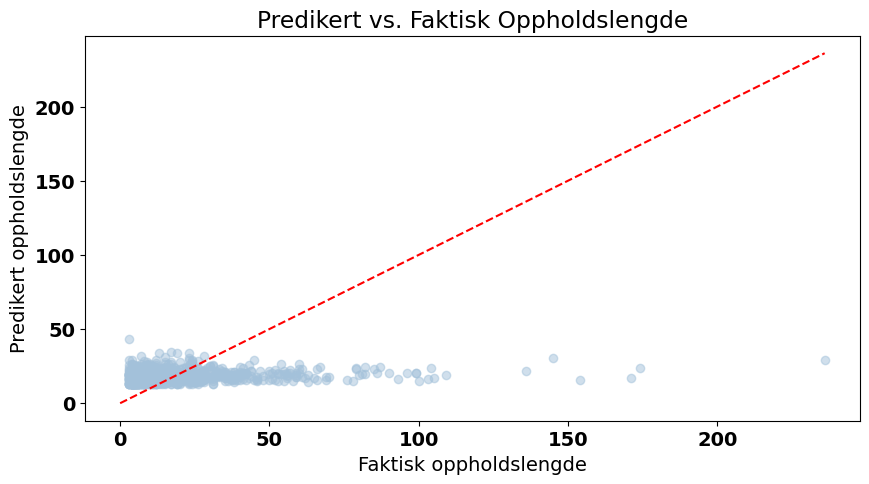

In [295]:
# Viktige mål for predikert oppholdslengde og faktisk oppholdslengde. 

print(f'Lengste predikerte oppholdslengde: {round(max(y_test_predikert), 2)}')
print(f'Korteste predikerte oppholdslengde: {round(min(y_test_predikert), 2)}')
print(f'Median faktisk oppholdslengde: {round(np.median(y_test), 2)}')
print(f'Median predikert oppholdslengde: {round(np.median(y_test_predikert), 2)}')

# Predikert mot faktiske oppholdslengde.

plt.figure(figsize=(10, 5))

plt.scatter(x=y_test, y=y_test_predikert, alpha=0.5, color="#A3C1DA")

max_value = max(max(y_test), max(y_test_predikert))
# Hvis punktene ligger langs den diagonale linjen, er predikasjonene korrekte.
plt.plot([0, max_value], [0, max_value], 'r--')

plt.xlabel('Faktisk oppholdslengde')
plt.ylabel('Predikert oppholdslengde')
plt.title('Predikert vs. Faktisk Oppholdslengde')

plt.show()

#### Antall korrekte prediksjoner

In [296]:
antall_korrekte_prediksjoner = np.sum(np.round(y_test) == np.round(y_test_predikert))

print(f'Antall korrekte prediksjoner: {antall_korrekte_prediksjoner}')

Antall korrekte prediksjoner: 26


In [297]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(best_rf, f)

#### Predikere oppholdslengde blant pasienter i Sampledata

#### Tilsvarende lik behandling som i raw_data

In [298]:
demographic_sample_df = pd.read_csv("./sample_data/demographic.csv")
hospital_sample_df = pd.read_csv("./sample_data/hospital.csv")
physiological_sample_df = pd.read_csv("./sample_data/physiological.txt", sep="\t")
severity_sample_df = pd.read_json("./sample_data/severity.json")

In [299]:
# Substituerer NaN verdier i fysiologiske data med eksempelverdier. 

phychological_df["serumalbumin"].fillna(3.5,inplace=True)
phychological_df["bilirubin"].fillna(1.01,inplace=True)
phychological_df["kreatinin"].fillna(1.01,inplace=True)
phychological_df["hvite_blodlegemer"].fillna(9,inplace=True) 
phychological_df["urinmengde"].fillna(2502,inplace=True)
phychological_df["blodurea_nitrogen"].fillna(6.5, inplace=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_31820\115904410.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\andre\AppData\Local\Temp\ipykernel_31820\115904410.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [300]:
columns_to_list = severity_sample_df.columns.to_list()
valid_columns = columns_to_list[2:]
severity_sample_df = severity_sample_df.explode(valid_columns, ignore_index=True)

In [301]:
demographic_sample_df = demographic_sample_df.drop_duplicates()

# Tilbakestiller indeksene

demographic_sample_df = demographic_sample_df.reset_index(drop=True)
hospital_sample_df = hospital_sample_df.reset_index(drop=True).drop(columns=['pasient_id'])
physiological_sample_df = physiological_sample_df.reset_index(drop=True).drop(columns=['pasient_id'])
severity_sample_df = severity_sample_df.reset_index(drop=True).drop(columns=['pasient_id'])

# Slår så sammen datasettene til et stort datasett: df
df_sample = pd.concat([demographic_sample_df, hospital_sample_df, physiological_sample_df, severity_sample_df], axis=1)

In [302]:
df_sample.head()

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
0,1,62.84998,male,11.0,$11-$25k,other,0,97.0,6.000000,69.0,22.0,36.00000,388.000,1.799805,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,2,37.0,None,None,22.398438,21.0,0.823975,0.764893,0,0,no,None,None,no dnr,10.0
1,22,48.70398,male,16.0,NaN,other,0,66.0,12.500000,125.0,30.0,37.00000,170.000,NaN,NaN,1.000000,133.0,7.519531,NaN,NaN,NaN,A1s,ARF/MOSF,1,MOSF w/Malig,2,26.0,None,0.0,36.09375,78.0,0.171997,0.08699,0,0,yes,0.1,0.001,no dnr,21.0
2,25,29.36099,female,17.0,$25-$50k,white,0,96.0,10.599609,112.0,20.0,37.00000,NaN,3.699707,1.399902,0.599976,137.0,NaN,NaN,NaN,NaN,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,1,0.0,None,0.0,26.0,32.0,0.738892,0.657959,0,0,no,0.9,0.9,no dnr,61.0
3,26,53.84000,male,NaN,under $11k,white,0,134.0,7.799805,106.0,22.0,37.89844,304.125,3.799805,0.500000,0.799927,141.0,7.379883,NaN,NaN,NaN,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,2,37.0,None,None,21.5,30.0,0.642944,0.541992,0,1,no,None,None,dnr ved innleggelse,4.0
4,29,30.10799,male,NaN,NaN,asian,0,92.0,8.798828,112.0,27.0,37.59375,225.000,NaN,NaN,0.399963,134.0,7.459961,NaN,NaN,NaN,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,1,9.0,None,None,31.097656,48.0,0.703979,0.61499,0,0,no,0.1,0.001,no dnr,120.0


In [303]:
# One hot encoding på sample data.

cols_to_encode_sample = ["kjønn", "inntekt", "etnisitet", "sykdomskategori", "sykdom_underkategori", "kreft", "dnr_status"]

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded_data = one_hot_encoder.fit_transform(df_sample[cols_to_encode_sample])

encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(cols_to_encode_sample))

df_sample_encoded = pd.concat([df_sample.drop(columns=cols_to_encode_sample), encoded_df], axis=1)

df_sample_encoded.head()

,pasient_id,alder,utdanning,sykehusdød,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori_id,dødsfall,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_dag,kjønn_female,kjønn_male,inntekt_$11-$25k,inntekt_$25-$50k,inntekt_>$50k,inntekt_under $11k,inntekt_nan,etnisitet_asian,etnisitet_black,etnisitet_hispanic,etnisitet_other,etnisitet_white,etnisitet_nan,sykdomskategori_ARF/MOSF,sykdomskategori_COPD/CHF/Cirrhosis,sykdomskategori_Cancer,sykdomskategori_Coma,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,kreft_metastatic,kreft_no,kreft_yes,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,dnr_status_no dnr,dnr_status_None
0,1,62.84998,11.0,0,97.0,6.000000,69.0,22.0,36.00000,388.000,1.799805,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,A1s,0,2,37.0,None,None,22.398438,21.0,0.823975,0.764893,0,0,None,None,10.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,22,48.70398,16.0,0,66.0,12.500000,125.0,30.0,37.00000,170.000,NaN,NaN,1.000000,133.0,7.519531,NaN,NaN,NaN,A1s,1,2,26.0,None,0.0,36.09375,78.0,0.171997,0.08699,0,0,0.1,0.001,21.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,25,29.36099,17.0,0,96.0,10.599609,112.0,20.0,37.00000,NaN,3.699707,1.399902,0.599976,137.0,NaN,NaN,NaN,NaN,A1s,1,1,0.0,None,0.0,26.0,32.0,0.738892,0.657959,0,0,0.9,0.9,61.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,26,53.84000,NaN,0,134.0,7.799805,106.0,22.0,37.89844,304.125,3.799805,0.500000,0.799927,141.0,7.379883,NaN,NaN,NaN,A1s,1,2,37.0,None,None,21.5,30.0,0.642944,0.541992,0,1,None,None,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,29,30.10799,NaN,0,92.0,8.798828,112.0,27.0,37.59375,225.000,NaN,NaN,0.399963,134.0,7.459961,NaN,NaN,NaN,A1s,0,1,9.0,None,None,31.097656,48.0,0.703979,0.61499,0,0,0.1,0.001,120.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [304]:
# Fjerner irrelevante kolonner. Se begrunnelse for hvorfor under behandling av raw_data.

irrelevant_columns = ["dødsfall", "pasient_id", "sykehusdød", "adl_pasient", "bilirubin", "sykdomskategori_id", "lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd", "apache_fysiologisk_score", 'dnr_status_no dnr']

df_sample_encoded = df_sample_encoded.drop(columns=irrelevant_columns, axis=1)

In [305]:
# Predikerer oppholdslengde i sample data og lagrer i csv-fil.

predicted_oppholdslengde = optimal_model.predict(df_sample_encoded)

df_predictions = df_sample_encoded.copy()

df_predictions['predikert_oppholdslengde'] = predicted_oppholdslengde

# Lagrer predikasjoner i predictions.csv. Vedlagt i prosjekt mappen.
df_predictions.to_csv("predictions.csv", index=False)

print("Predikasjoner lagret i predictions.csv")


Predikasjoner lagret i predictions.csv


#### Kode for å regne ut medianverdien til alle numeriske kolonner.

In [306]:

'''
binary_columns = [
    'kjønn_female', 'kjønn_male',
    'inntekt_$11-$25k', 'inntekt_$25-$50k', 'inntekt_>$50k', 'inntekt_under $11k', 'inntekt_nan',
    'etnisitet_asian', 'etnisitet_black', 'etnisitet_hispanic', 'etnisitet_other', 
    'etnisitet_white', 'etnisitet_nan',
    'sykdomskategori_ARF/MOSF', 'sykdomskategori_COPD/CHF/Cirrhosis', 
    'sykdomskategori_Cancer', 'sykdomskategori_Coma',
    'sykdom_underkategori_ARF/MOSF w/Sepsis', 'sykdom_underkategori_CHF', 
    'sykdom_underkategori_COPD', 'sykdom_underkategori_Cirrhosis', 
    'sykdom_underkategori_Colon Cancer', 'sykdom_underkategori_Coma', 
    'sykdom_underkategori_Lung Cancer', 'sykdom_underkategori_MOSF w/Malig',
    'kreft_metastatic', 'kreft_no', 'kreft_yes'
]

# Filtering out binary columns to get numeric columns
numeric_columns = [col for col in X_test.columns if col not in binary_columns]

# Calculating median for numeric columns
median_values = X_test[numeric_columns].median()

# Convert to dictionary
median_dict = median_values.to_dict()

# Print or use the median_dict as needed
print(median_dict)
'''

"\nbinary_columns = [\n    'kjønn_female', 'kjønn_male',\n    'inntekt_$11-$25k', 'inntekt_$25-$50k', 'inntekt_>$50k', 'inntekt_under $11k', 'inntekt_nan',\n    'etnisitet_asian', 'etnisitet_black', 'etnisitet_hispanic', 'etnisitet_other', \n    'etnisitet_white', 'etnisitet_nan',\n    'sykdomskategori_ARF/MOSF', 'sykdomskategori_COPD/CHF/Cirrhosis', \n    'sykdomskategori_Cancer', 'sykdomskategori_Coma',\n    'sykdom_underkategori_ARF/MOSF w/Sepsis', 'sykdom_underkategori_CHF', \n    'sykdom_underkategori_COPD', 'sykdom_underkategori_Cirrhosis', \n    'sykdom_underkategori_Colon Cancer', 'sykdom_underkategori_Coma', \n    'sykdom_underkategori_Lung Cancer', 'sykdom_underkategori_MOSF w/Malig',\n    'kreft_metastatic', 'kreft_no', 'kreft_yes'\n]\n\n# Filtering out binary columns to get numeric columns\nnumeric_columns = [col for col in X_test.columns if col not in binary_columns]\n\n# Calculating median for numeric columns\nmedian_values = X_test[numeric_columns].median()\n\n# Convert 